In [1]:
from glob import glob
import os
import numpy as np
import pandas as pd
import librosa.display
from tqdm import tqdm

import tensorflow as tf

import tensorflow_io as tfio

import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt


import random

TESLA_K40c = '/gpu:1'
GTX_1080 = '/gpu:0'

GPU = GTX_1080

DIR = "/mnt/backup/arthur/Free_Music_Archive/fma_medium/"

In [2]:
# data = pd.read_csv("/home/arthursrr/Documentos/Audio_Inpainting/Datasets/fma_small_train.csv")
data = pd.read_csv("/home/arthursrr/Documentos/Audio_Inpainting/Datasets/fma_small_val.csv")
# data  = pd.read_csv("/home/arthursrr/Documentos/Audio_Inpainting/Datasets/fma_medium_test.csv")

data = data['0'].tolist()


In [3]:
random.seed(0)
audio_paths= []
for i in glob(DIR+"**/*.wav"):
    name = os.path.basename(i).split('.wav')[0]
    if int(name) in data:
        audio_paths.append(i)

random.shuffle(audio_paths)
len(audio_paths)

1600

In [4]:
def audio_to_spectrogram(path, rate=16000, duration = 30, frame_length=256, fft_length=255, stride=64, fmin=0, fmax=8000):
    """
    retunr tensor format [Time, Frequence]
    """
    with tf.device(GPU):
        raw_audio = tf.io.read_file(path)
        audio_tensor = tf.audio.decode_wav(raw_audio, desired_channels=1, desired_samples=rate*duration)
        audio_tensor = tf.squeeze(audio_tensor.audio.numpy(), axis=[-1])
        spectrogram = tf.math.abs(tf.signal.stft(audio_tensor, 
                                frame_length=frame_length, 
                                frame_step=stride, 
                                fft_length=fft_length, 
                                window_fn=tf.signal.hann_window, 
                                pad_end=True))
    return spectrogram

In [ ]:
def audio_to_mdct(path, rate=16000, duration = 30, frame_length=256):
    """
    retunr tensor format [Time, Frequence]
    """
    with tf.device(GPU):
        halflen = frame_length // 2
        
        raw_audio = tf.io.read_file(path)
        audio_tensor = tf.audio.decode_wav(raw_audio, desired_channels=1, desired_samples=rate*duration)
        audio_tensor = tf.squeeze(audio_tensor.audio.numpy(), axis=[-1])
        udio_tensor_pad = tf.pad(waveform, [[halflen, 0],])
        spectrogram = tf.signal.mdct(audio_tensor, frame_length, pad_end=True,
                        window_fn=tf.signal.vorbis_window)
    return spectrogram

In [ ]:
def mdct_to_wave(spectrogram, rate=16000, duration = 30, frame_length=256):
    """
    retunr tensor format [Time]
    """
    with tf.device(GPU):
        samples = rate*duration
        halflen = frame_length // 2
        inverse_mdct = tf.signal.inverse_mdct(mdct,window_fn=tf.signal.vorbis_window)
        wave = inverse_mdct[halflen: halflen + samples]
    return wave

In [5]:
def griffin_lim(S, frame_length=256, fft_length=255, stride=64):
    '''
    TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    with tf.device(TESLA_K40c):
        S = tf.expand_dims(S, 0)
        S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
        y = tf.signal.inverse_stft(S_complex, frame_length, stride, fft_length=fft_length)
        for i in range(1000):
            est = tf.signal.stft(y, frame_length, stride, fft_length=fft_length)
            angles = est / tf.cast(tf.maximum(1e-16, tf.abs(est)), tf.complex64)
            y = tf.signal.inverse_stft(S_complex * angles, frame_length, stride, fft_length=fft_length)
        result = tf.squeeze(y, 0)
    return result

In [6]:
spec = audio_to_spectrogram(audio_paths[0])
spec

<tf.Tensor: shape=(7500, 128), dtype=float32, numpy=
array([[7.0271254e-01, 2.3703580e+00, 4.0924959e+00, ..., 1.3664518e-03,
        5.7648867e-04, 1.2494859e-03],
       [8.8519365e-01, 3.3413634e+00, 9.0924149e+00, ..., 3.0855155e-03,
        4.9681515e-03, 2.6523601e-03],
       [1.7400852e+01, 2.1058840e+01, 2.3140568e+01, ..., 9.1720112e-03,
        1.4865657e-02, 1.4601183e-02],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [7]:
wave = griffin_lim(spec, frame_length=256, fft_length=255, stride=64).numpy()
ipd.Audio(wave, rate=16000)

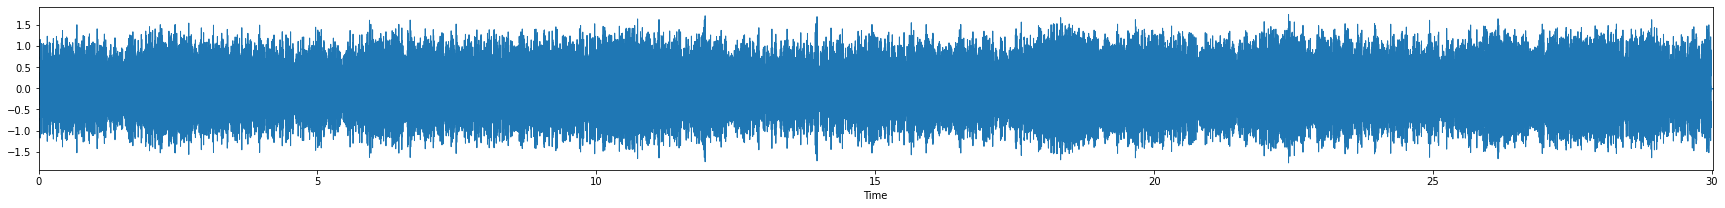

In [16]:
plt.figure(figsize=(30, 3))
librosa.display.waveplot(wave, sr=16000)

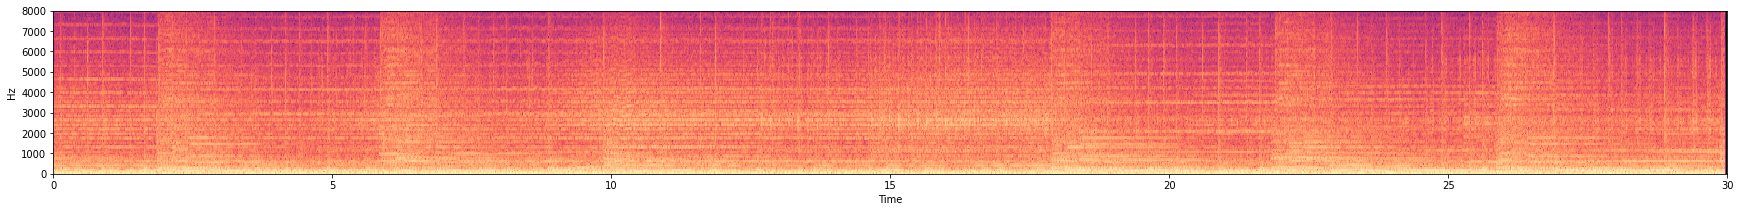

In [17]:
plt.figure(figsize=(30, 3))
librosa.display.specshow(librosa.power_to_db(spec.numpy().T, ref=np.max), sr=16000, y_axis='hz', x_axis='time', hop_length=64)

In [44]:
data_np = None
data_spec = None
first_time = True 
flag = True
count = 0

for i in tqdm(audio_paths):
    spec = audio_to_spectrogram(i)
    spec = tf.expand_dims(spec, axis=0)
    ini = 0
    end = ini+128
    while end < spec.get_shape().as_list()[1]:
        if data_spec == None:
            data_spec = spec[:,ini:end,:]
        else:
            data_spec = tf.concat([data_spec, spec[:,ini:end,:]], 0)
        ini = end
        end = ini+128
        
        if data_spec.get_shape().as_list()[0]%20000 == 0:
            if flag == True:
                data_np = data_spec.numpy()              
                flag = False
            else:
                data_np = np.concatenate((data_np, data_spec.numpy()), axis=0)
            del data_spec
            data_spec = None
        count+=1
if data_spec != None:
    data_np = np.concatenate((data_np, data_spec.numpy()), axis=0)

100%|██████████| 5586/5586 [36:34<00:00,  2.55it/s]  


In [45]:
data_np.shape

(323988, 128, 128)

In [ ]:
# from sklearn.utils import shuffle
# data_np = shuffle(data_np)

In [46]:
wave = griffin_lim(data_np[0], frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave, rate=16000)

In [47]:
np.save("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", np.expand_dims(data_np, axis=3))

In [48]:
# Mascaramento
data_np.shape
# data_np = np.squeeze(data_np, axis=3)
# data_np.shape

(323988, 128, 128)

In [ ]:
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_train.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_1.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_2.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_3.npy")

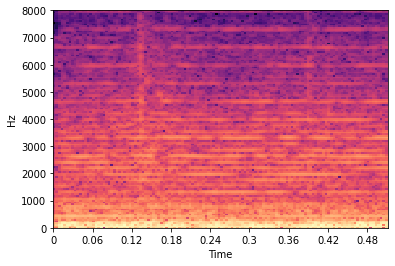

In [35]:
librosa.display.specshow(librosa.power_to_db(spec.numpy()[:128].T, ref=np.max), sr=16000, y_axis='hz', x_axis='time', hop_length=64)

In [8]:
# seed = data_np.shape[0] para treino e teste e data_np.shape[0]+[0,1,2] para validação
np.random.seed(data_np.shape[0])
#Porcentagem de oclusao do sprectro [10%...70%]
qnt_min_cortes = int(data_np.shape[1]*0.1)
qnt_max_cortes = int(data_np.shape[1]*0.7)
qnt_cortes = np.random.randint(qnt_min_cortes, qnt_max_cortes,size=data_np.shape[0])
qnt_cortes

NameError: name 'data_np' is not defined

In [40]:
data_np = spec.numpy()[:128].T
# for i in tqdm(range(data_np.shape[0])):
time_cortes = np.random.permutation(np.arange(128))[:60]
data_np[:,time_cortes] = 0.0
time_cortes

array([126,  65,  10,  59,   2,  17,  27,  81,  38,  58,  34,  67, 108,
        87,  61, 102,  88,  66, 118,  36,  28, 109,  74,  46,   9, 127,
        80,  75,  26,  12, 119, 103,  32,  89,  72,  44,  40,  42,  92,
        76,  37,  63, 121,  18,  19,  90, 124,  60, 110,  50, 106,   3,
        11,  56,   0,  20,  47,  55,  22,  99])

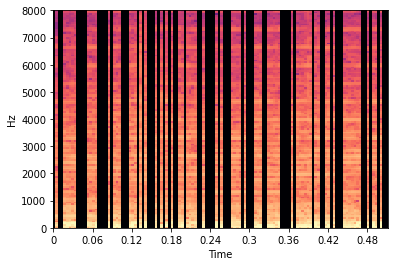

In [41]:
librosa.display.specshow(librosa.power_to_db(data_np, ref=np.max), sr=16000, y_axis='hz', x_axis='time', hop_length=64)

In [42]:
wave = griffin_lim(data_np.T, frame_length=256, fft_length=255, stride=64).numpy()
ipd.Audio(wave, rate=16000)

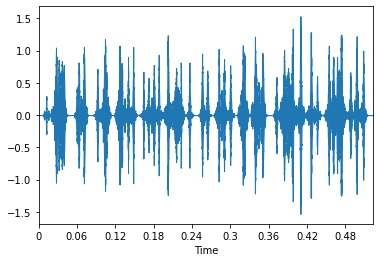

In [43]:
librosa.display.waveplot(wave, sr=16000)

In [54]:
data_np = np.expand_dims(data_np, axis=3)
data_np.shape

(323988, 128, 128, 1)

In [55]:
np.save("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", data_np)

In [ ]:
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_train.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_1.npy", mmap_mode='c') 
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_2.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_3.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_train.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val_1.npy", mmap_mode='c') 
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val_2.npy")
# data = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val_3.npy")

In [ ]:
data = np.expand_dims(data, axis=3)
data.shape

In [ ]:
np.save("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_2.npy", data)

In [ ]:
audio_cortado = None
for i in range(58,116):
    if i==58:
        audio_cortado = data_np[i,:,:,0]
    else:
        audio_cortado = np.concatenate((audio_cortado, data_np[i,:,:,0]), axis=0)
audio_cortado.shape

In [ ]:
audio = None
for i in range(58,116):
    if i==58:
        audio = data_l[i,:,:,0]
    else:
        audio = np.concatenate((audio, data_l[i,:,:,0]), axis=0)
audio.shape

In [ ]:
audio_cortado

In [ ]:
wave = griffin_lim(audio_cortado, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave, rate=16000)

In [ ]:
wave = griffin_lim(audio, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave, rate=16000)

In [1]:
!pip freeze

absl-py==0.9.0
appdirs==1.4.4
asn1crypto==0.24.0
astunparse==1.6.3
attrs==19.3.0
audioread==2.1.8
backcall==0.1.0
bernhard==0.2.6
bleach==3.1.5
bottle==0.12.19
cachetools==4.1.0
certifi==2020.4.5.1
cffi==1.14.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.6.0
cryptography==2.1.4
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
distlib==0.3.0
docker==4.4.4
efficientnet==1.1.0
entrypoints==0.3
filelock==3.0.12
Flask==1.1.2
future==0.18.2
gast==0.3.3
Glances==3.1.6.2
google-auth==1.14.2
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.28.1
h5py==2.10.0
hyperopt==0.2.5
idna==2.6
ifaddr==0.1.7
imagecodecs==2020.2.18
imageio==2.8.0
importlib-metadata==1.6.0
importlib-resources==1.5.0
ipykernel==5.2.1
ipython==7.14.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
itsdangerous==1.1.0
jedi==0.17.0
Jinja2==2.11.2
joblib==0.15.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.3
jupyter-console==6.1.0
jupyter-core==4.6.3
kaggle==1.5.8
Keras==2.4.3
Keras-Applications==1.0.8
keras-contrib @ 